In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler, minmax_scale

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D # for 3D plots

from itertools import cycle
from sklearn.mixture import GaussianMixture

In [2]:
info_estudiantes=pd.read_csv('./datos/informacion_por_estudiante_de_IP.csv')
envios=pd.read_csv('./datos/todos_los_envios.csv')
problemas= pd.read_csv('./datos/todos_problemas.csv')

C:\Users\User\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3135: DtypeWarning: Columns (134) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Analisis general (Coorrelación y limpieza de datos)

In [3]:
envios_por_estudiante=(envios.groupby(['estudiante_id']).count())
envios_por_estudiante['Num_envios'] = envios_por_estudiante['estado']
envios_por_estudiante['Num_envios']

estudiante_id
363      25
364      80
365      33
366      28
367      31
       ... 
6301     94
6302     35
6303    149
6304     76
6305     17
Name: Num_envios, Length: 4971, dtype: int64

In [4]:
#Tener envíos por nivel del estudiante , luego tener las notas por cada estudiante en cada nivel y hacer una coorrelación , a partir de allí explorar otros factores.

In [5]:
info_estudiantes_det = info_estudiantes[['id','n1_global','n2_global','n3_global','n4_global','retiro','semestre']]

In [6]:
info_estudiantes_det= info_estudiantes_det[(info_estudiantes_det['n1_global']>=0) & (info_estudiantes_det['n1_global']<6) &
                                           (info_estudiantes_det['n2_global']>=0)  & (info_estudiantes_det['n2_global']<6) &
                                           (info_estudiantes_det['n3_global']>=0) & (info_estudiantes_det['n3_global']<6) &
                                           (info_estudiantes_det['n4_global']>=0) & (info_estudiantes_det['n4_global']<6) ]
info_estudiantes_det= info_estudiantes_det[(info_estudiantes_det['n1_global']>0) |  (info_estudiantes_det['n2_global']>0) |
                                         (info_estudiantes_det['n3_global']>0) | (info_estudiantes_det['n4_global']>0)]
info_estudiantes_det = info_estudiantes_det.rename(columns={"id": "estudiante_id"})

In [7]:
info_estudiantes_det['estudiante_id'] = info_estudiantes_det['estudiante_id'].astype(str)
info_estudiantes_det['semestre'] = info_estudiantes_det['semestre'].astype(str)

info_estudiantes_det['est_sem_id'] =  info_estudiantes_det['estudiante_id'] + info_estudiantes_det['semestre'] 

info_estudiantes_det.fillna(value="NR", inplace=True)
info_estudiantes_det

,estudiante_id,n1_global,n2_global,n3_global,n4_global,retiro,semestre,est_sem_id
4,867,2.19,2.89,3.350000,3.97,NR,202010,867202010
5,910,4.57,4.92,4.460000,3.71,NR,202010,910202010
7,1186,3.67,4.08,4.320000,3.44,NR,202010,1186202010
8,1394,4.58,4.31,4.190000,4.37,NR,202010,1394202010
9,1436,4.94,4.70,3.680000,2.65,NR,202010,1436202010
...,...,...,...,...,...,...,...,...
7918,5286,4.30,4.52,5.000000,0.00,NR,202210,5286202210
7921,5709,4.70,3.48,4.800000,0.00,NR,202210,5709202210
7922,5865,4.60,2.92,3.942857,0.00,NR,202210,5865202210
7924,5996,4.70,4.72,4.314286,0.00,NR,202210,5996202210


In [8]:
def conseguir_anio(texto):
    return (texto.split()[0]).split("-")[0]
def conseguir_mes(texto):
    return (texto.split()[0]).split("-")[1]
def conseguir_dia(texto):
    return (texto.split()[0]).split("-")[2]

In [9]:
envios['Anio'] = (envios['timestamp'].apply(conseguir_anio))
envios['Mes'] = (envios['timestamp'].apply(conseguir_mes))
envios['Dia'] = (envios['timestamp'].apply(conseguir_dia))
envios['Anio'] = envios['Anio'].astype(int)
envios['Mes'] = envios['Mes'].astype(int)
envios['Dia'] = envios['Dia'].astype(int)

In [10]:
envios['semestre'] = np.where((envios['Anio']==2022) & (envios['Mes']<6) & (envios['Mes']>=1),"202210",
                     np.where((envios['Anio']==2021) & (envios['Mes']<=12) & (envios['Mes']>=8),"202120",
                     np.where((envios['Anio']==2021) & (envios['Mes']<6) & (envios['Mes']>=1),"202110",
                     np.where((envios['Anio']==2020) & (envios['Mes']<=12) & (envios['Mes']>=8),"202020",
                     np.where((envios['Anio']==2020) & (envios['Mes']<6) & (envios['Mes']>=1),"202010",
                     np.where((envios['Anio']==2019) & (envios['Mes']<=12) & (envios['Mes']>=8),"201920",
                     np.where((envios['Anio']==2019)  & (envios['Mes']<6) & (envios['Mes']>=1),"201910",
                              
                     np.where((envios['Anio']==2021)  & (envios['Mes']<8) & (envios['Mes']>=6),"202119",
                     np.where((envios['Anio']==2020)  & (envios['Mes']<8) & (envios['Mes']>=6),"202019",
                     np.where((envios['Anio']==2022)  & (envios['Mes']<=8) & (envios['Mes']>=6),"202219","No match date"))))))))))

In [11]:
envios=envios.dropna()

In [12]:
envios_mod= envios.copy()

In [13]:
envios_mod['estudiante_id'] = envios_mod['estudiante_id'].astype(str)
envios_mod['semestre'] = envios_mod['semestre'].astype(str)

envios_mod['est_sem_id'] =  envios_mod['estudiante_id'] + envios_mod['semestre'] 

In [14]:
envios_mod

,id,numero,timestamp,avance,estudiante_id,problema_id,resultado_estudiante_id,estado,Anio,Mes,Dia,semestre,est_sem_id
0,179,1,2019-09-09 16:47:13.610937,100,524,117.0,65,OK,2019,9,9,201920,524201920
1,180,1,2019-09-09 17:20:15.109540,100,526,117.0,66,OK,2019,9,9,201920,526201920
2,181,1,2019-09-09 17:28:32.380640,100,525,152.0,67,OK,2019,9,9,201920,525201920
3,182,1,2019-09-09 17:31:04.890352,0,525,149.0,68,ER,2019,9,9,201920,525201920
4,183,1,2019-09-09 17:32:11.534749,100,525,150.0,69,OK,2019,9,9,201920,525201920
...,...,...,...,...,...,...,...,...,...,...,...,...,...
300408,300595,1,2022-08-06 14:24:57.239117,100,5906,154.0,135627,OK,2022,8,6,202219,5906202219
300409,300596,1,2022-08-06 14:56:34.644659,30,5906,157.0,135628,ER,2022,8,6,202219,5906202219
300410,300597,2,2022-08-06 15:02:20.309052,50,5906,157.0,135628,ER,2022,8,6,202219,5906202219
300411,300598,3,2022-08-06 15:08:44.696018,100,5906,157.0,135628,OK,2022,8,6,202219,5906202219


In [15]:
problemas = problemas.rename(columns={"id": "problema_id"})

In [16]:
envios_problemas= pd.merge(envios_mod,problemas,on='problema_id')

In [17]:
envios_problemas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300411 entries, 0 to 300410
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       300411 non-null  int64  
 1   numero                   300411 non-null  int64  
 2   timestamp                300411 non-null  object 
 3   avance                   300411 non-null  int64  
 4   estudiante_id            300411 non-null  object 
 5   problema_id              300411 non-null  float64
 6   resultado_estudiante_id  300411 non-null  int64  
 7   estado_x                 300411 non-null  object 
 8   Anio                     300411 non-null  int32  
 9   Mes                      300411 non-null  int32  
 10  Dia                      300411 non-null  int32  
 11  semestre                 300411 non-null  object 
 12  est_sem_id               300411 non-null  object 
 13  titulo                   300411 non-null  object 
 14  curs

In [18]:
envios_por_nivel_por_estudiante=(envios_problemas.groupby(['est_sem_id','nivel']).count())
envios_por_nivel_por_estudiante['Num_envios'] = envios_por_nivel_por_estudiante['funcion']
envios_por_nivel_por_estudiante = envios_por_nivel_por_estudiante['Num_envios'].reset_index()
envios_por_nivel_por_estudiante

,est_sem_id,nivel,Num_envios
0,1000202010,1,22
1,1000202010,2,4
2,1000202010,3,4
3,1001202010,1,7
4,1001202010,2,5
...,...,...,...
18286,999202010,1,45
18287,999202010,2,33
18288,999202010,3,51
18289,999202010,4,13


In [19]:
info_estudiantes_det.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6819 entries, 4 to 7925
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   estudiante_id  6819 non-null   object 
 1   n1_global      6819 non-null   float64
 2   n2_global      6819 non-null   float64
 3   n3_global      6819 non-null   float64
 4   n4_global      6819 non-null   float64
 5   retiro         6819 non-null   object 
 6   semestre       6819 non-null   object 
 7   est_sem_id     6819 non-null   object 
dtypes: float64(4), object(4)
memory usage: 479.5+ KB


In [89]:
df_final= pd.merge(envios_por_nivel_por_estudiante,info_estudiantes_det,on='est_sem_id')
df_final

,est_sem_id,nivel,Num_envios,estudiante_id,n1_global,n2_global,n3_global,n4_global,retiro,semestre
0,1003202110,1,18,1003,5.07,4.63,4.50,5.00,NR,202110
1,1003202110,2,4,1003,5.07,4.63,4.50,5.00,NR,202110
2,1003202110,3,5,1003,5.07,4.63,4.50,5.00,NR,202110
3,1009202010,1,14,1009,3.38,3.36,4.10,3.69,NR,202010
4,1009202010,2,6,1009,3.38,3.36,4.10,3.69,NR,202010
...,...,...,...,...,...,...,...,...,...,...
14389,982202010,3,16,982,4.83,3.41,4.02,4.53,NR,202010
14390,982202010,4,4,982,4.83,3.41,4.02,4.53,NR,202010
14391,983202010,1,7,983,4.55,2.40,3.17,4.35,NR,202010
14392,983202010,2,17,983,4.55,2.40,3.17,4.35,NR,202010


In [90]:
df_final.fillna(value="NR", inplace=True)

In [91]:
df_final.groupby(['retiro']).count()

,est_sem_id,nivel,Num_envios,estudiante_id,n1_global,n2_global,n3_global,n4_global,semestre
retiro,,,,,,,,,
NR,13038,13038,13038,13038,13038,13038,13038,13038,13038
P,43,43,43,43,43,43,43,43,43
R,1313,1313,1313,1313,1313,1313,1313,1313,1313


In [92]:
df_final.describe()

,nivel,Num_envios,n1_global,n2_global,n3_global,n4_global
count,14394.000000,14394.000000,14394.000000,14394.000000,14394.000000,14394.000000
mean,2.393289,18.020425,4.145100,3.598973,3.337105,2.390204
std,1.088988,16.426784,0.947176,1.223356,1.539343,1.953121
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,7.000000,3.980000,3.022500,2.630000,0.000000
50%,2.000000,14.000000,4.450000,3.920000,3.857143,2.880000
75%,3.000000,23.000000,4.780000,4.510000,4.514286,4.230000
max,4.000000,238.000000,5.120000,5.050000,5.180000,5.490000


In [93]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14394 entries, 0 to 14393
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   est_sem_id     14394 non-null  object 
 1   nivel          14394 non-null  int64  
 2   Num_envios     14394 non-null  int64  
 3   estudiante_id  14394 non-null  object 
 4   n1_global      14394 non-null  float64
 5   n2_global      14394 non-null  float64
 6   n3_global      14394 non-null  float64
 7   n4_global      14394 non-null  float64
 8   retiro         14394 non-null  object 
 9   semestre       14394 non-null  object 
dtypes: float64(4), int64(2), object(4)
memory usage: 1.2+ MB


<AxesSubplot:>

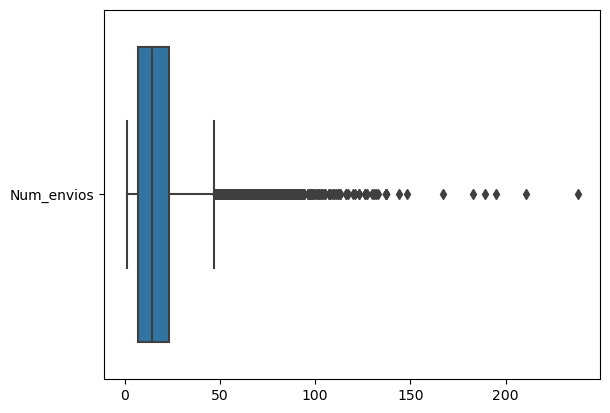

In [94]:
sns.boxplot(data=df_final[['Num_envios']], orient="h")

<AxesSubplot:>

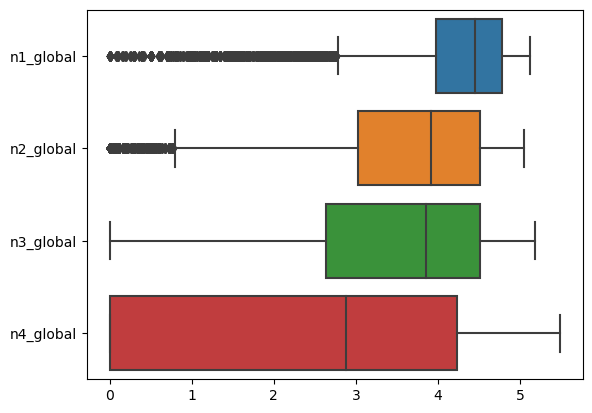

In [95]:
sns.boxplot(data=df_final[['n1_global','n2_global','n3_global','n4_global']], orient="h")

In [96]:
# Seleccionamos los no Outliers usando percentiles
per = 95

# Depuración de las anomalías en las columnas.
num_envios = (df_final['Num_envios'] < np.percentile(df_final['Num_envios'] , per))


In [97]:
df_final= df_final[num_envios].copy()

In [98]:
per_b = 5
n1_global_no_out= (df_final['n1_global'] > np.percentile(df_final['n1_global'] , per_b))

In [99]:
df_final= df_final[n1_global_no_out].copy()

<AxesSubplot:>

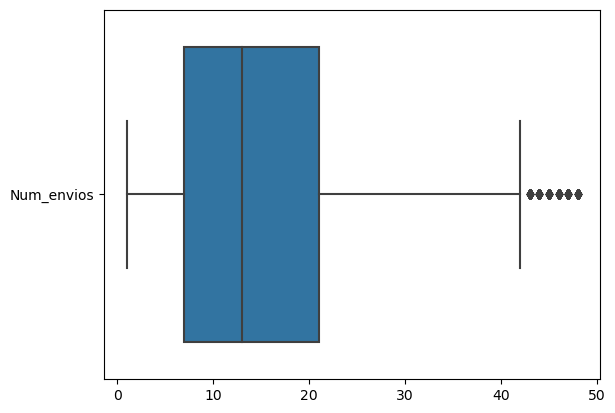

In [100]:
sns.boxplot(data=df_final[['Num_envios']], orient="h")

<AxesSubplot:>

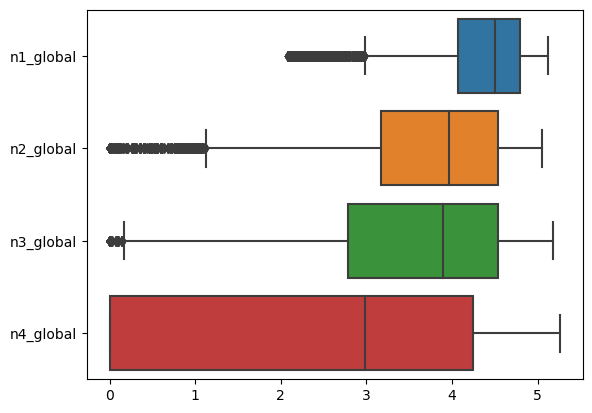

In [101]:
sns.boxplot(data=df_final[['n1_global','n2_global','n3_global','n4_global']], orient="h")

In [30]:
df_final[(df_final['retiro']=='NR')].describe()

,nivel,Num_envios,n1_global,n2_global,n3_global,n4_global
count,11904.000000,11904.000000,11904.000000,11904.000000,11904.000000,11904.000000
mean,2.426999,15.583921,4.348832,3.782857,3.581108,2.611957
std,1.101981,10.786683,0.630180,1.081915,1.368582,1.917855
min,1.000000,1.000000,2.090000,0.000000,0.000000,0.000000
25%,1.000000,7.000000,4.100000,3.360000,3.114286,0.000000
50%,2.000000,13.000000,4.500000,4.050000,4.000000,3.275000
75%,3.000000,22.000000,4.800000,4.580000,4.590000,4.310000
max,4.000000,48.000000,5.120000,5.050000,5.180000,5.266667


In [31]:
df_final[(df_final['retiro']=='R') |  (df_final['retiro']=='r')].describe()

,nivel,Num_envios,n1_global,n2_global,n3_global,n4_global
count,1037.000000,1037.000000,1037.000000,1037.000000,1037.000000,1037.000000
mean,2.174542,14.077146,3.824255,2.528033,1.583857,0.636827
std,1.048720,11.254678,0.783241,1.295663,1.406412,1.102526
min,1.000000,1.000000,2.080000,0.000000,0.000000,0.000000
25%,1.000000,5.000000,3.280000,1.710000,0.000000,0.000000
50%,2.000000,11.000000,4.040000,2.670000,1.480000,0.000000
75%,3.000000,20.000000,4.450000,3.610000,2.740000,1.030000
max,4.000000,48.000000,5.000000,4.970000,4.900000,4.680000


<AxesSubplot:>

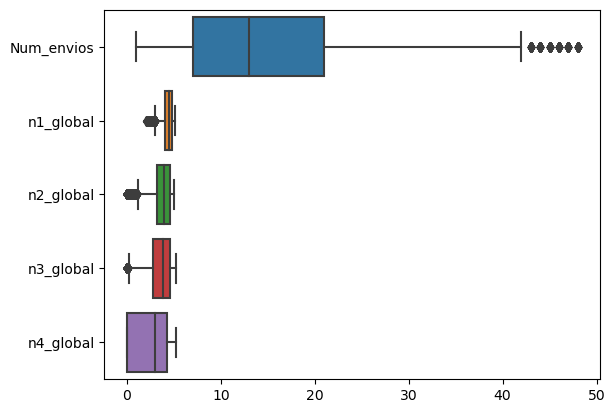

In [32]:
sns.boxplot(data=df_final[['Num_envios','n1_global','n2_global','n3_global','n4_global']], orient="h")

<AxesSubplot:xlabel='n2_global'>

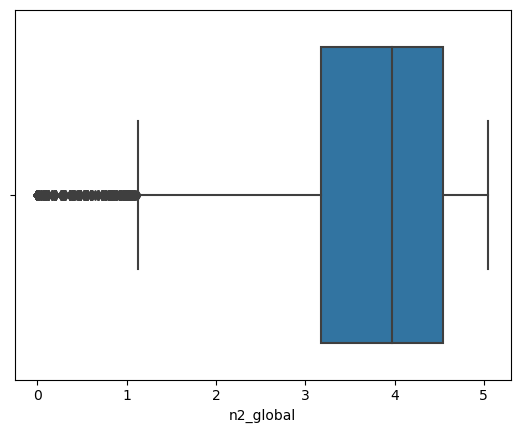

In [33]:
sns.boxplot(x=df_final["n2_global"])

In [34]:
df_final['retiroOno'] = np.where((df_final['retiro']=='NR'),1,0)

In [35]:
columnas=['Num_envios','n1_global','n2_global','n3_global','n4_global','retiroOno']
df_nivel1= (df_final[(df_final['nivel']==1) ])
df_nivel2=df_final[(df_final['nivel']==2) ]
df_nivel3= df_final[(df_final['nivel']==3) ]
df_nivel4=df_final[(df_final['nivel']==4) ]
corr_df1= df_nivel1[['Num_envios','n1_global']].corr(method='pearson')
corr_df2= df_nivel2[['Num_envios','n2_global']].corr(method='pearson')
corr_df3= df_nivel3[['Num_envios','n3_global']].corr(method='pearson')
corr_df4= df_nivel4[['Num_envios','n4_global']].corr(method='pearson')

In [102]:
df_nivel1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3501 entries, 0 to 14391
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   est_sem_id     3501 non-null   object 
 1   nivel          3501 non-null   int64  
 2   Num_envios     3501 non-null   int64  
 3   estudiante_id  3501 non-null   object 
 4   n1_global      3501 non-null   float64
 5   n2_global      3501 non-null   float64
 6   n3_global      3501 non-null   float64
 7   n4_global      3501 non-null   float64
 8   retiro         3501 non-null   object 
 9   semestre       3501 non-null   object 
 10  retiroOno      3501 non-null   int32  
dtypes: float64(4), int32(1), int64(2), object(4)
memory usage: 314.5+ KB


In [103]:
df_nivel2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3486 entries, 1 to 14392
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   est_sem_id     3486 non-null   object 
 1   nivel          3486 non-null   int64  
 2   Num_envios     3486 non-null   int64  
 3   estudiante_id  3486 non-null   object 
 4   n1_global      3486 non-null   float64
 5   n2_global      3486 non-null   float64
 6   n3_global      3486 non-null   float64
 7   n4_global      3486 non-null   float64
 8   retiro         3486 non-null   object 
 9   semestre       3486 non-null   object 
 10  retiroOno      3486 non-null   int32  
dtypes: float64(4), int32(1), int64(2), object(4)
memory usage: 313.2+ KB


In [104]:
df_nivel3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3210 entries, 2 to 14393
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   est_sem_id     3210 non-null   object 
 1   nivel          3210 non-null   int64  
 2   Num_envios     3210 non-null   int64  
 3   estudiante_id  3210 non-null   object 
 4   n1_global      3210 non-null   float64
 5   n2_global      3210 non-null   float64
 6   n3_global      3210 non-null   float64
 7   n4_global      3210 non-null   float64
 8   retiro         3210 non-null   object 
 9   semestre       3210 non-null   object 
 10  retiroOno      3210 non-null   int32  
dtypes: float64(4), int32(1), int64(2), object(4)
memory usage: 288.4+ KB


In [105]:
df_nivel4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2786 entries, 6 to 14390
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   est_sem_id     2786 non-null   object 
 1   nivel          2786 non-null   int64  
 2   Num_envios     2786 non-null   int64  
 3   estudiante_id  2786 non-null   object 
 4   n1_global      2786 non-null   float64
 5   n2_global      2786 non-null   float64
 6   n3_global      2786 non-null   float64
 7   n4_global      2786 non-null   float64
 8   retiro         2786 non-null   object 
 9   semestre       2786 non-null   object 
 10  retiroOno      2786 non-null   int32  
dtypes: float64(4), int32(1), int64(2), object(4)
memory usage: 250.3+ KB


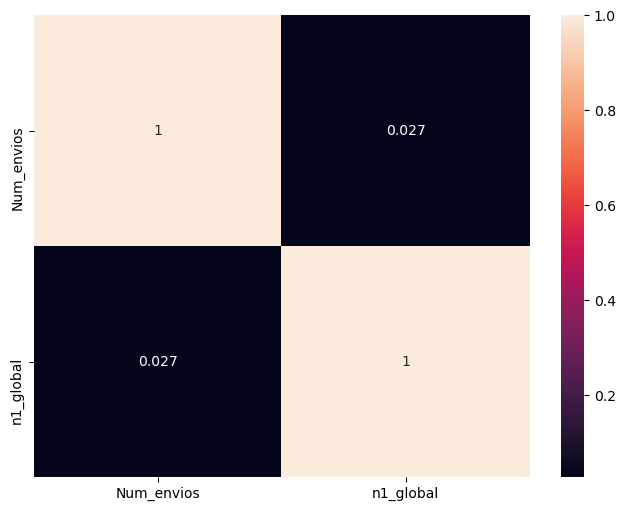

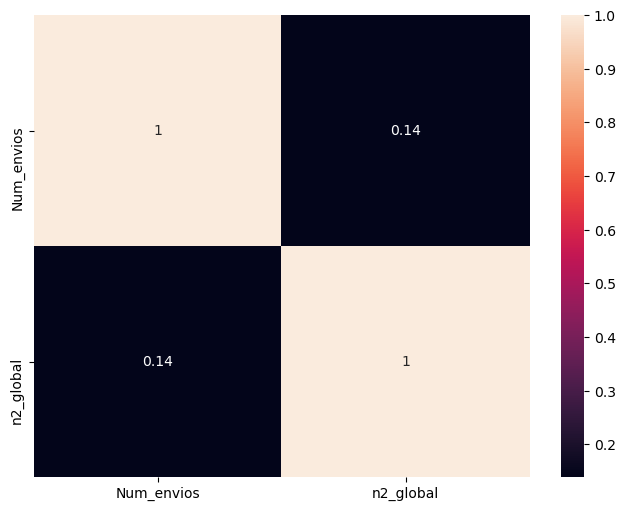

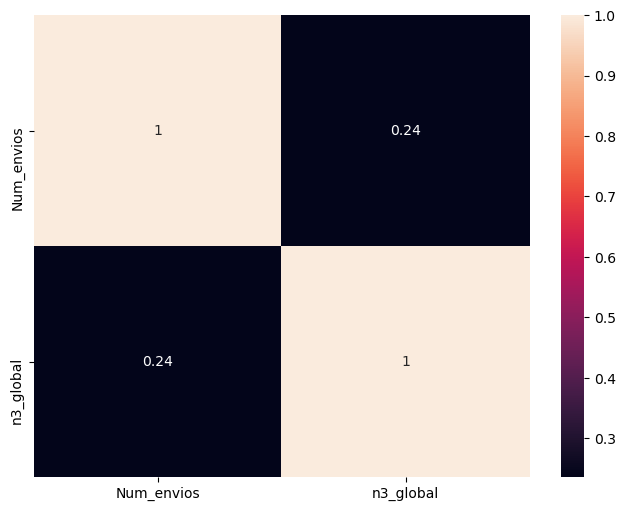

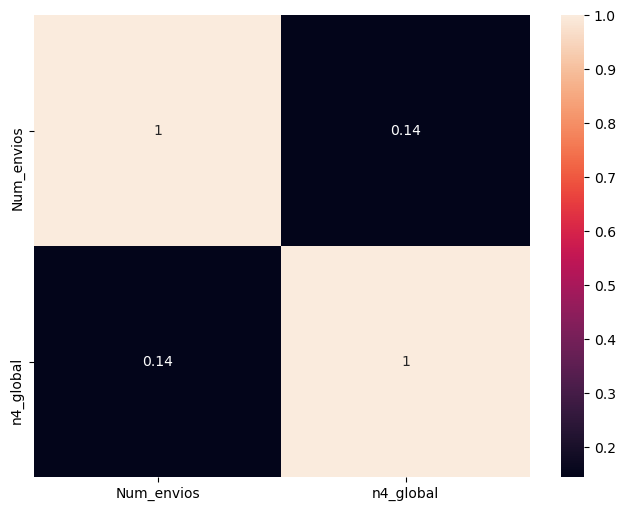

In [36]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df1[['Num_envios','n1_global']], annot=True)
plt.show()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df2[['Num_envios','n2_global']], annot=True)
plt.show()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df3[['Num_envios','n3_global']], annot=True)
plt.show()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df4[['Num_envios','n4_global']], annot=True)
plt.show()

In [37]:
df_final['Esmayor1'] = np.where(df_final['n1_global'] > 0 , 1, 0)
((df_final).groupby(['Esmayor1']).count()).rename(columns={"estudiante_id": "num"})['num']

Esmayor1
1    12983
Name: num, dtype: int64

In [38]:
df_final['Esmayor2'] = np.where(df_final['n2_global'] > 0 , 1, 0)
((df_final).groupby(['Esmayor2']).count()).rename(columns={"estudiante_id": "num"})['num']

Esmayor2
0      298
1    12685
Name: num, dtype: int64

In [39]:
df_final['Esmayor3'] = np.where(df_final['n3_global'] > 0 , 1, 0)
((df_final).groupby(['Esmayor3']).count()).rename(columns={"estudiante_id": "num"})['num']

Esmayor3
0     1120
1    11863
Name: num, dtype: int64

In [40]:
df_final['Esmayor4'] = np.where(df_final['n4_global'] > 0 , 1, 0)
((df_final).groupby(['Esmayor4']).count()).rename(columns={"estudiante_id": "num"})['num']
#Probar el analisis sin los datos de la nota 4 y ver los rangos que tienen las notas en general.
#Ver si el estudiante retiró la materia (Adjuntar columna retiro de tabla observatorio)

Esmayor4
0    4258
1    8725
Name: num, dtype: int64

In [41]:
(((df_final[(df_final['retiro'] == 'NR')]).groupby(['Esmayor4']).count()).rename(columns={"estudiante_id": "num"})['num'])

Esmayor4
0    3552
1    8352
Name: num, dtype: int64

In [42]:
(((df_final[(df_final['retiro'] == 'R') | (df_final['retiro'] == 'r')]).groupby(['Esmayor4']).count()).rename(columns={"estudiante_id": "num"})['num'])

Esmayor4
0    691
1    346
Name: num, dtype: int64

In [43]:
# Es mirar porque el nivel 4 tiene tantas notas vacías y ver si retiraron.
# Intentar normalizar  o tratar de darle un rango al número de envíos o realizar agrupaciones (Categorías) graficarlo. ¿ Que pasa en comparación con los que no realizaron envíos con los que si ?.


# Como se calculan los puntos a detalle.
# Separar los envíos que se hizo por tarea y por envíos adicionales.

In [44]:
''' Duda: No se entiende muy bien el uso de la columna retiro ( R,r,A y P) en la tabla observatorio , ya que no se entiende muy bien cuando se retira y cuando no , hay datos nulos y vacíos
    Supuestos: COn la columna retiro: Si es nulo no retiró, P= Pendiente, A= ? , R o r= Retiró, vacío = no se sabe, pero aplica para estudiantes del programa de la alcaldía , pero deberían ir nulos'''

' Duda: No se entiende muy bien el uso de la columna retiro ( R,r,A y P) en la tabla observatorio , ya que no se entiende muy bien cuando se retira y cuando no , hay datos nulos y vacíos\n    Supuestos: COn la columna retiro: Si es nulo no retiró, P= Pendiente, A= ? , R o r= Retiró, vacío = no se sabe, pero aplica para estudiantes del programa de la alcaldía , pero deberían ir nulos'

## Gráficas Importantes

In [45]:
info_estudiantes_det

,estudiante_id,n1_global,n2_global,n3_global,n4_global,retiro,semestre,est_sem_id
4,867,2.19,2.89,3.350000,3.97,NR,202010,867202010
5,910,4.57,4.92,4.460000,3.71,NR,202010,910202010
7,1186,3.67,4.08,4.320000,3.44,NR,202010,1186202010
8,1394,4.58,4.31,4.190000,4.37,NR,202010,1394202010
9,1436,4.94,4.70,3.680000,2.65,NR,202010,1436202010
...,...,...,...,...,...,...,...,...
7918,5286,4.30,4.52,5.000000,0.00,NR,202210,5286202210
7921,5709,4.70,3.48,4.800000,0.00,NR,202210,5709202210
7922,5865,4.60,2.92,3.942857,0.00,NR,202210,5865202210
7924,5996,4.70,4.72,4.314286,0.00,NR,202210,5996202210


In [46]:
df_info_hist= info_estudiantes_det.copy()

In [47]:
df_info_hist.fillna(value="NR", inplace=True)

In [48]:
df_info_hist['EsMayor0_n1'] = np.where(df_info_hist['n1_global']>0,1,0)
df_info_hist['EsMayor0_n2'] = np.where(df_info_hist['n2_global']>0,1,0)
df_info_hist['EsMayor0_n3'] = np.where(df_info_hist['n3_global']>0,1,0)
df_info_hist['EsMayor0_n4'] = np.where(df_info_hist['n4_global']>0,1,0)

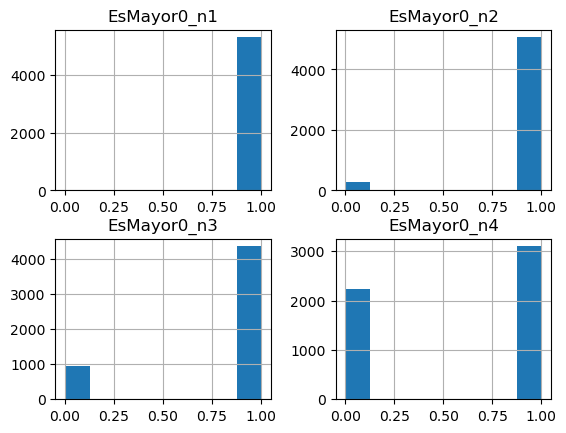

In [49]:
hist = (df_info_hist[['EsMayor0_n1','EsMayor0_n2','EsMayor0_n3','EsMayor0_n4']])[df_info_hist['retiro'] == "NR"].hist(bins=8)

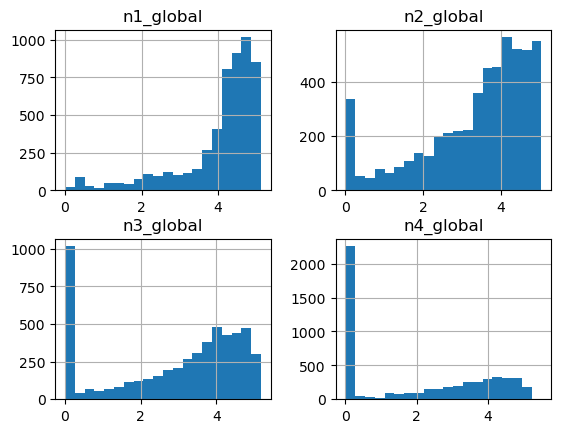

In [50]:
hist = (df_info_hist[['n1_global','n2_global','n3_global','n4_global']])[df_info_hist['retiro'] == "NR"].hist(bins=20)

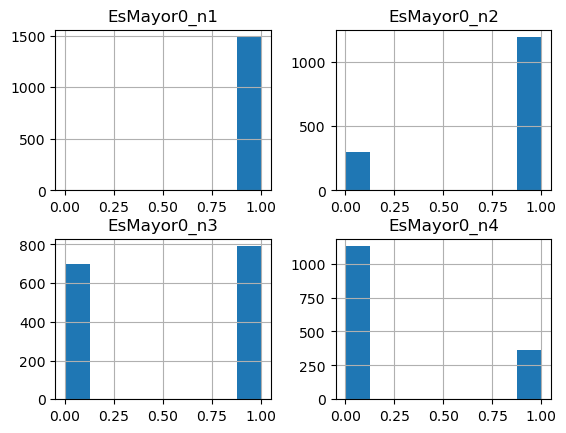

In [51]:
hist = (df_info_hist[['EsMayor0_n1','EsMayor0_n2','EsMayor0_n3','EsMayor0_n4']])[(df_info_hist['retiro'] == "R") | (df_info_hist['retiro'] == "r") | (df_info_hist['retiro'] == "P") | (df_info_hist['retiro'] == "A")].hist(bins=8)

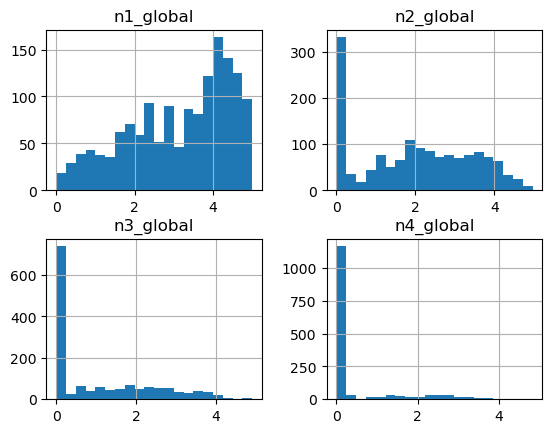

In [52]:
hist = (df_info_hist[['n1_global','n2_global','n3_global','n4_global']])[(df_info_hist['retiro'] == "R") | (df_info_hist['retiro'] == "r") | (df_info_hist['retiro'] == "P") | (df_info_hist['retiro'] == "A")].hist(bins=20)

In [ ]:
#Comment: se podría repetir todos los niveles pero se obtendrá casi que el mismo resultado que este nivel. Una misma conclusión , 
#este grupo de datos se pueden clasificar en 4 grupos principales, unos que hacen muchos envíos y sacan una alta nota en el nivel, pocos y baja nota , muchos y baja nota, pocos y alta nota. 

# Este clustering se puede mejorar con una dimensión más.